In [1]:
import nbimporter # to import methods from another notebook
import manta_file_processing as mfp
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import time
import random
import os

Importing Jupyter notebook from manta_file_processing.ipynb


In [2]:
heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")

In [3]:
from importlib import reload
reload(mfp)

Importing Jupyter notebook from manta_file_processing.ipynb


<module 'manta_file_processing' from 'manta_file_processing.ipynb'>

In [4]:
if os.name=="nt":
    folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some"
else:
    folder="/tf/notebooks/data/0_manta_selected_annotated_some"
print("os = "+os.name)
print("folder: "+folder+"\n ---")
dataset=mfp.get_manta_files(folder=folder)

os = posix
folder: /tf/notebooks/data/0_manta_selected_annotated_some
 ---
total:1801
labelled:295


In [5]:
df=dataset[dataset.body_landmark_path.isnull()==False].sample(frac=1)
manta_data=np.array(df[["image_path","body_landmark_path"]])
#data=np.array([df.image_path,df.body_landmark_path])
manta_data.shape

(295, 2)

In [6]:
image_size=[100,100]
heatmap_size=[33,33]

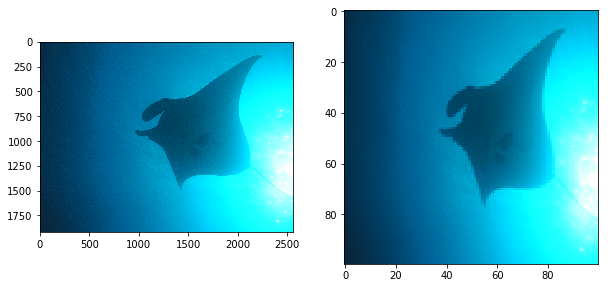

In [7]:
im_path,blm_path = manta_data[56]
image = Image.open(im_path)
body_landmarks=mfp.extract_body_landmarks(blm_path)
heatmaps=mfp.gen_heatmaps(body_landmarks,image_size)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 10))
axes[0].imshow(image)

image1=mfp.image_to_numpy(image,image_size)
axes[1].imshow(mfp.denormalize(image1))    
#axes[2].imshow(image[:,::-1])   
plt.show()


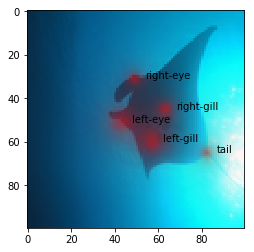

In [8]:
mfp.apply_heatmaps(image,heatmaps)

In [9]:
def flip_image(image,heatmaps):
    flip_image=image[::-1,:,]
    flip_heatmap=heatmaps[::-1,:,]
    return flip_image,flip_heatmap

In [10]:
X=[]
y=[]
i=0
print ("total:" + str(manta_data.shape[0]))

for im_path,blm_path in manta_data:
    try:
        image = Image.open(im_path)
        body_landmarks=mfp.extract_body_landmarks(blm_path)
    except:
        print(" \n Error on "+blm_path)
        
    image=mfp.image_to_numpy(image,image_size)
    if image.shape[2]>3:
        image=image[:,:,:3]
    numpy_heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size=heatmap_size)
    #numpy_heatmaps=mfp.heatmaps_to_numpy(heatmaps)
    
    #if image.shape[2]>3:
    #    image=image[:,:,:3]
        #print("\n More then 3 channels")
        #print(blm_path)
        #numpy_heatmaps=None
    if numpy_heatmaps[:,:,4:].sum()==0:
        numpy_heatmaps=None
    
    if numpy_heatmaps is not None and numpy_heatmaps.sum()>0:
        y.append(numpy_heatmaps[:,:,4:])
        X.append(image) 
        flip_img, flip_hm=flip_image(image,numpy_heatmaps)
        y.append(flip_hm[:,:,4:])
        X.append(flip_img) 
        
    print(i,end=" ")
    i+=1

X=np.array(X)
y=np.array(y)
print("\n====================")
print("Done.\nX.shape="+str(X.shape))
print("y.shape="+str(y.shape))


total:295
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25  
 Error on /tf/notebooks/data/0_manta_selected_annotated_some/0012 Laverna/12-F-20130627-LEI-MichelleOoi-LAVERNA-2.json
26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244

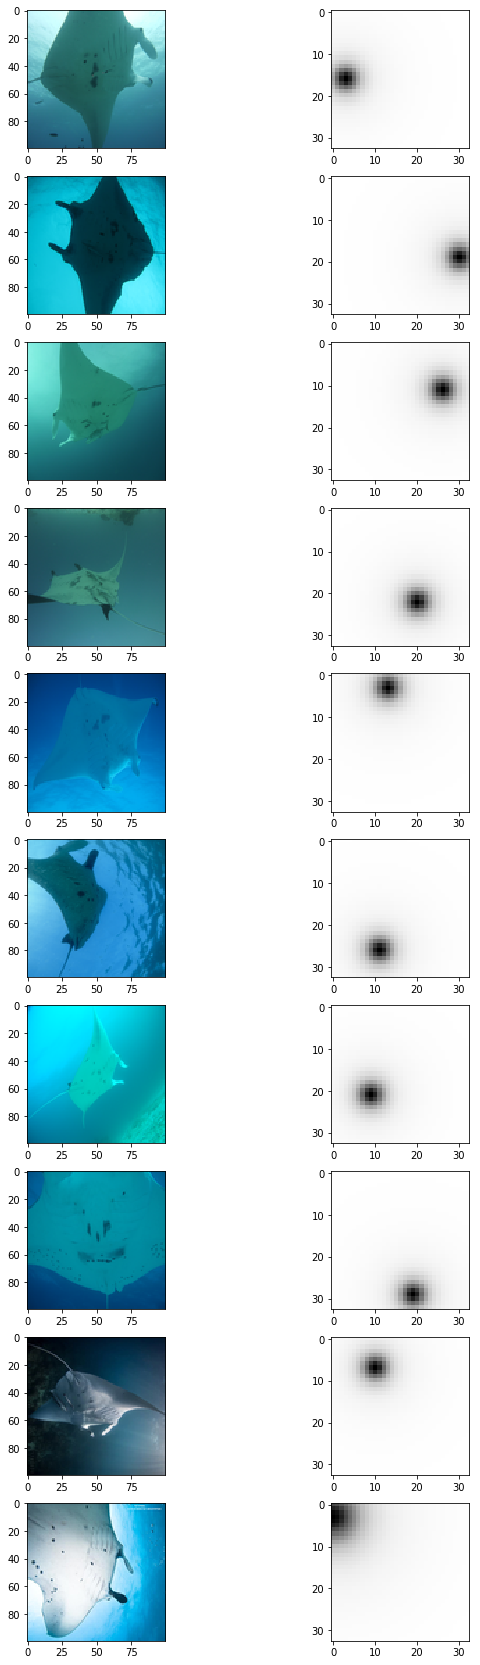

In [11]:
n=10
samples=random.sample(list(np.arange(X.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=2,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X[s]))
    axes[i,1].imshow(y[s][:,:,0],cmap='Greys')
plt.show()


In [12]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense,Conv2DTranspose
from tensorflow.python.keras.layers import BatchNormalization,AveragePooling2D,Activation

from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam

In [13]:
import copy
input_shape=copy.copy(image_size)
input_shape.append(3)
batch_size=8
nb_train_samples=int(round(X.shape[0]*0.95,0))
X_train=X[:nb_train_samples]
X_test =X[nb_train_samples:]
y_train=y[:nb_train_samples]
y_test =y[nb_train_samples:]

In [14]:
#pip install h5py
#pip install cython
#restart jupyther
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
vgg16_net.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
from tensorflow.keras.models import Model
mymodel = Model(vgg16_net.get_input_at(0), vgg16_net.layers[17].get_output_at(0))
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [16]:
model=Sequential()
model.add(vgg16_net)
#model.add(mymodel)

model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=256,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=128,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=1,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
batch_normalization_v1 (Batc (None, 3, 3, 512)         2048      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 256)         1179904   
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 15, 15, 128)       295040    
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 15, 15, 128)       512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 31, 31, 64)        73792     
__________

In [17]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['binary_accuracy'])

In [23]:
start_time = time.time()

history=model.fit(X_train,y_train,batch_size=32,epochs=200,validation_split=0.1)

training_time=round(time.time() - start_time,0)

Train on 465 samples, validate on 52 samples
Epoch 1/200
465/465 [==============================] - 2s 4ms/sample - loss: 4.1058 - binary_accuracy: 0.0000e+00 - val_loss: 3.8591 - val_binary_accuracy: 0.0000e+00
Epoch 2/200
465/465 [==============================] - 2s 4ms/sample - loss: 4.1123 - binary_accuracy: 0.0000e+00 - val_loss: 3.8726 - val_binary_accuracy: 0.0000e+00
Epoch 3/200
465/465 [==============================] - 2s 4ms/sample - loss: 4.0969 - binary_accuracy: 0.0000e+00 - val_loss: 3.8712 - val_binary_accuracy: 0.0000e+00
Epoch 4/200
465/465 [==============================] - 2s 4ms/sample - loss: 4.0900 - binary_accuracy: 0.0000e+00 - val_loss: 3.8696 - val_binary_accuracy: 0.0000e+00
Epoch 5/200
465/465 [==============================] - 2s 4ms/sample - loss: 4.0992 - binary_accuracy: 0.0000e+00 - val_loss: 3.8582 - val_binary_accuracy: 0.0000e+00
Epoch 6/200
465/465 [==============================] - 2s 3ms/sample - loss: 4.0966 - binary_accuracy: 0.0000e+00 - val_

KeyboardInterrupt: 

In [ ]:
print("\nTraining time :'--- %s min %s sec ---" % (training_time//60,training_time%60) )
loss = history.history['loss']
val_loss= history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.show()

In [24]:
pred=model.predict(X_test)
print(X_test.shape)
print(pred.shape)

(27, 100, 100, 3)
(27, 33, 33, 1)


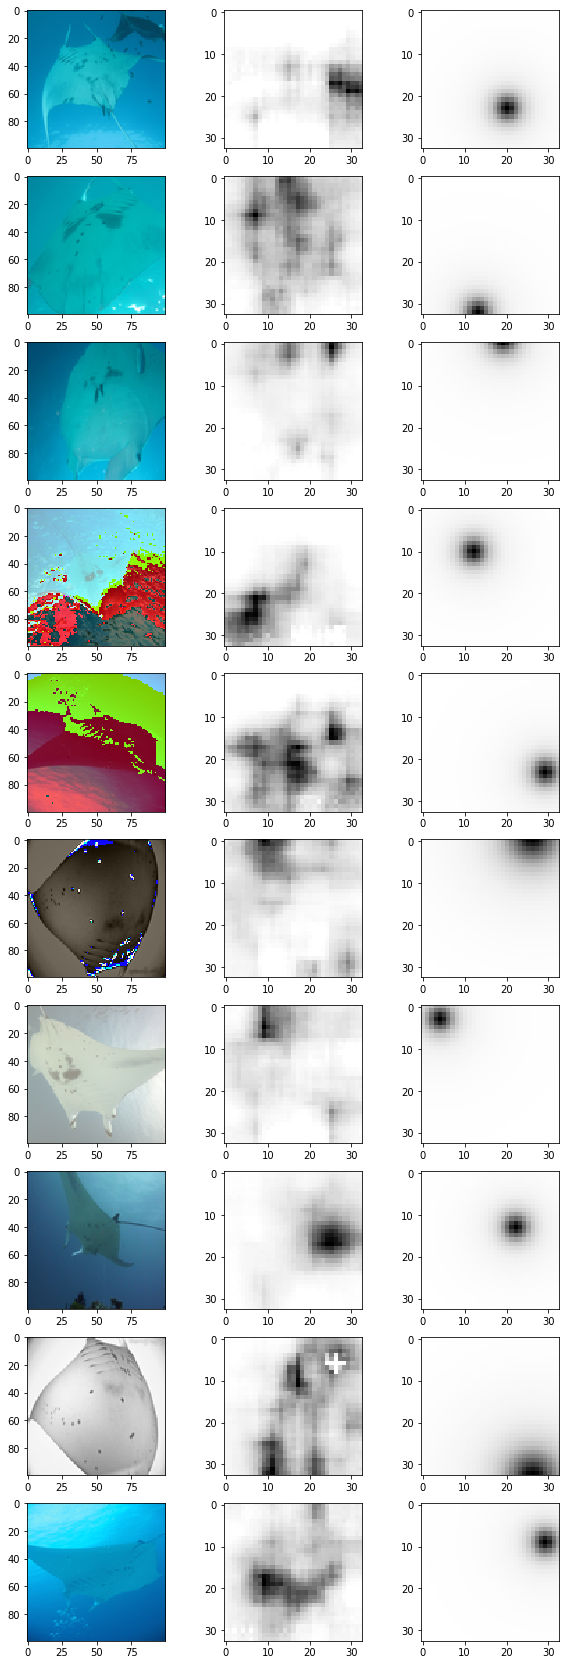

In [25]:
n=10#X_test.shape[0]
samples=random.sample(list(np.arange(pred.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=3,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X_test[s]))
    axes[i,1].imshow(pred[s][:,:,0],cmap='Greys')
    axes[i,2].imshow(y_test[s][:,:,0],cmap='Greys')
plt.show()

In [ ]:
mfp.apply_heatmaps(mfp.denormalize(X_test[5]),pred[5])

In [ ]:
# large heatmap
# Распределение Коши  1/(1+((x-xo)/r)**2)
+ validation set
+ get rid of maxPooling layer?
+ augmentation
+ labelling
